## 4. Unified Model Inference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, Adagrad, Adadelta
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LambdaCallback
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model,Sequence

from utilities import plot_tensor
from deeplabv3pMS import Deeplabv3
import math

In [2]:
from joblib import Parallel, delayed

### 4.1. Initialization

In [3]:
video_name_str = "./Demo_Video/"
results_path = './Demo_Results/'

In [4]:
seq_len = 10
seq_delta = 20
batch_size = 5

### 4.2. Load data

In [5]:
images_dataset_path_list = sorted(glob.glob(video_name_str+'*.jpg'))

In [6]:
Height,Width = cv2.imread(images_dataset_path_list[0],0).shape
Height_Ext = math.ceil(Height/16)*16
Width_Ext = math.ceil(Width/16)*16
print(Height,Width,Height_Ext,Width_Ext)

480 720 480 720


In [7]:
input_dataset = np.zeros([len(images_dataset_path_list),Height_Ext,Width_Ext,3],dtype = np.float32)
def read_input_images(i):
    input_dataset[i,:Height,:Width,:] = cv2.imread(images_dataset_path_list[i])
Parallel(n_jobs=-1, verbose=2, prefer="threads")(delayed(read_input_images)(i) for i in range(len(images_dataset_path_list)));

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.3s finished


### 4.3. Create Generator

In [8]:
def extract_clip_indices(begin,end,head,clip_len,delta):
    position = head - begin;
    sequence = np.arange(begin,end+1,1)
    if head < clip_len*delta:
        clip_indices = np.flip([sequence[position+i*delta] for i in range(clip_len)])
    else:
        clip_indices = np.flip([sequence[position-i*delta] for i in range(clip_len)])
    return clip_indices 
    
def extract_clip_indices_list(begin,end,head_list,clip_len,delta):
    clip_indices_list = []
    for head in head_list:
        clip_indices_list.append(extract_clip_indices(begin,end,head,clip_len,delta))
    return clip_indices_list    

In [9]:
class unified_test_X_generator(Sequence):
    def __init__(self,input_dataset,seq_len,seq_delta,batch_size):
        # Pre settings
        self.data = input_dataset
        self.seq_len = seq_len
        self.seq_delta = seq_delta
        self.batch_size = batch_size
        self.clip_frames_list = extract_clip_indices_list(0,
                                                          self.data.shape[0],
                                                          np.arange(self.data.shape[0]),
                                                          self.seq_len,self.seq_delta)
        #print(self.clip_frames_list)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.shape[0] / self.batch_size))
    
    def __getitem__(self, i):
        
        batch_X = []

        for j in range(i*self.batch_size,min(self.data.shape[0],(i+1)*self.batch_size)):
            batch_X.append(self.data[self.clip_frames_list[j],:,:,:])

        batch_X = np.asarray(batch_X)
        
        return [batch_X[:,:,:,:,:]/255,batch_X[:,-1,:,:,:]]
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

In [10]:
X_generator = unified_test_X_generator(input_dataset,seq_len=seq_len,seq_delta=seq_delta,batch_size=batch_size)

(5, 10, 480, 720, 3)


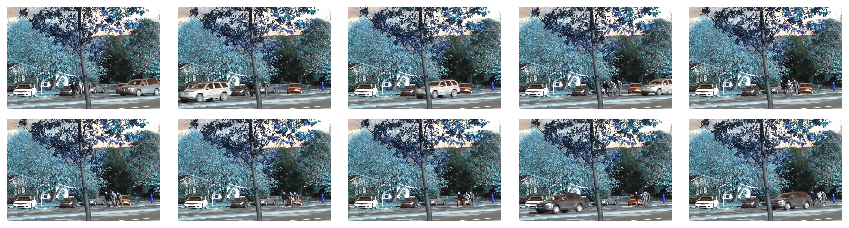

In [11]:
print(X_generator.__getitem__(0)[0].shape)
plot_tensor(X_generator.__getitem__(20)[0][0,:,:,:])

### 4.4. Load Semantic model

In [12]:
# The first and last classes are irrelevant ones. Only the middle 13 classes are meaningful.
deeplabv3p = Deeplabv3(input_tensor=None,input_shape=(None,None,3),classes=15) 

In [13]:
kernel_tensor = tf.zeros((3,3,1))

In [14]:
inputs = keras.layers.Input(shape=(None,None,3))
upscaled_inputs = keras.layers.UpSampling2D(interpolation='bilinear')(inputs)
out_up = deeplabv3p(upscaled_inputs)
out_raw = deeplabv3p(inputs)
out_up_back = keras.layers.MaxPooling2D()(out_up)
out_up_back_epd = Lambda(lambda x: tf.expand_dims(x,axis=1))(out_up_back)
out_epd = Lambda(lambda x: tf.expand_dims(x,axis=1))(out_raw)
out_concatinate = keras.layers.Concatenate(axis=1)([out_up_back_epd,out_epd])
ms_hidden = Conv3D(filters=1, kernel_size=(5, 5, 1),
                    padding='same',data_format='channels_first',
                    activation='linear')(out_concatinate)

ms_hidden = keras.layers.LeakyReLU(alpha=0.01)(ms_hidden)

ms_hidden = Lambda(lambda x: tf.squeeze(x,axis=1))(ms_hidden)

ms_out = Activation('softmax')(ms_hidden)

ms_out_person = Lambda(lambda x: tf.nn.erosion2d(x, filters=kernel_tensor, strides=(1,1,1,1),
                                                 padding='SAME',data_format='NHWC',dilations=(1,1,1,1)))(ms_out[:,:,:,1:2])

ms_out1 = tf.concat([ms_out[:,:,:,0:1],ms_out_person],axis=-1)
ms_out2 = tf.concat([ms_out1,ms_out[:,:,:,2:15]],axis=-1)

MS_model = Model(inputs,ms_out2,name='MS_model')

In [15]:
MS_model.load_weights('./Semantic_model_weights/Smaller_MS_model_final.h5')

In [16]:
for layer in MS_model.layers:
    layer.trainable = False

### 4.5. Load Temporal Model

In [17]:
temporal_model = Sequential()
temporal_model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),strides=2,
                   input_shape=(seq_len, None, None, 3),
                   padding='same', return_sequences=True))
temporal_model.add(BatchNormalization())

temporal_model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),strides=2,
                   padding='same', return_sequences=False))
temporal_model.add(BatchNormalization())

temporal_model.add(UpSampling2D())
temporal_model.add(Conv2D(filters=10, kernel_size=(3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))
temporal_model.add(UpSampling2D())
temporal_model.add(Conv2D(filters=1, kernel_size=(3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

In [18]:
temporal_model.load_weights('./Temporal_model_weights/3_temporal_model_fall.h5')

In [19]:
for layer in temporal_model.layers:
    layer.trainable = False 

### 4.6. Load Top Model

In [20]:
probability_stack = keras.layers.Concatenate(axis=-1)([temporal_model.output for i in range(15)])
inverse_probability_stack = Lambda(lambda x: 1.0-x)(probability_stack)
joint_probabilitys_0 = Lambda(lambda x: (x[0]*x[1])[0])([probability_stack,MS_model.outputs])
joint_probabilitys_1 = Lambda(lambda x: (x[0]*x[1])[0])([inverse_probability_stack,MS_model.outputs])
class MinMaxConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value=0.0, max_value=1.0):
        self.min = min_value
        self.max = max_value

    def clip(self, w):
        m = tf.keras.backend.clip(w,self.min,self.max)

    def __call__(self, w):
        return tf.keras.backend.clip(w,0.0,1.0)
part_0 = keras.layers.Dense(1, use_bias=False, kernel_constraint=MinMaxConstraint())(joint_probabilitys_0)
part_1 = keras.layers.Dense(1, use_bias=False, kernel_constraint=MinMaxConstraint())(joint_probabilitys_1)   
total_prob = Lambda(lambda x: x[0]+x[1])([part_0,part_1])
unified_model = Model(inputs=[temporal_model.input,MS_model.input], outputs=total_prob)

In [21]:
# Coeeficients for the first and last classes are irrelevant ones. Only the middle 13 classes are meaningful.
part_0_weights = [np.array([[0.],[1.],[0.],[1.],[1.],[0.],[1.],[1.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])]
part_1_weights = [np.array([[0.],[1.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])]

In [22]:
unified_model.layers[-3].set_weights(part_0_weights)
unified_model.layers[-2].set_weights(part_1_weights)

### 4.7. Predict and Save

In [23]:
y_pred_raw = unified_model.predict(X_generator,max_queue_size = 10, workers = 8, verbose=1)
y_pred = np.where(y_pred_raw>0.5, 1.0, 0.0)[:,0:Height,0:Width,:]

120/120 [==============================] - 186s 2s/step


In [24]:
for k in range(len(y_pred)):
    y_pred_temp = np.concatenate((y_pred[k]*255, y_pred[k]*255, y_pred[k]*255), axis=-1)
    cv2.imwrite(results_path+str(k+1).zfill(6)+".png",y_pred_temp)

### 4.8. Illustrations

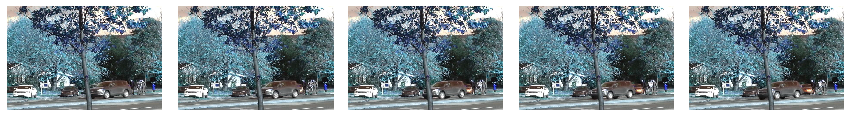

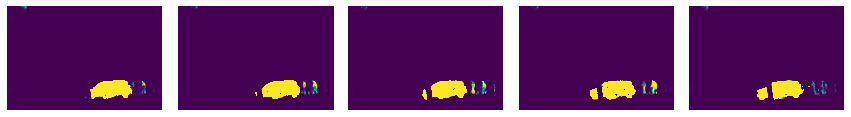

In [25]:
check_index = 20
plot_tensor(X_generator.__getitem__(check_index)[0][:,-1,:,:,:])
plot_tensor(y_pred_raw[check_index*batch_size:(check_index+1)*batch_size])